<h1 style="color:#54a7b5">3D Computer Vision (WS25/26) - Project</h1>

<h2 style="color:#007b90">General Information</h2>

Upload: 29.10.2025

**Intermediate Deadline**: 27.11.2025 (Step 1-2)

**Final Deadline**: 23.01.2026 (Step 1-5)

<h3 style="color:#003476">Your Group</h3>

Submitted by Group XX: 
- Aishwaryaraj Chandel
- Shivam singh
- Paula Nebgen

<h3 style="color:#003476">Submission</h3>

Please hand in a single **.zip** file named according to the pattern "**groupXX**" (e.g. group00). The contents of the .zip should be as follows:
- folder with the same name as the **.zip** file
    - **.ipynb** file
    - **.html** export of .ipynb with all the outputs you got
    - **data** folder containing necessary files to run the code

By submitting this exercise, you confirm the following:
- **All people** listed above **contributed** to this solution
- **No other people** were **involved** in this solution
- **No contents** of this solution were **copied from others** (this includes people, large language models, websites, etc.)

<h3 style="color:#003476">Final Presentation</h3>

You will be required to present your solution in a 20 minute presentation, which includes:
- Problem Overview
- Solution Overview (e.g. pseudo code, mathematical formulas, visualizations)
- Describe challenges & optimizations

After the presentation, there will be 10 minutes of questions and answers about your work.


<h2 style="color:#007b90">3D Scene Reconstruction - Task Overview</h2>

Your task in this exercise is to do a dense reconstruction of a scene. This will involve multiple steps that you will encounter and learn about as the semester progresses. You can start implementing individual steps as soon as you learn about them or wait until you have learned more to implement everything together. In the latter case, be mindful that this exercise is designed for an entire semester and the workload is accordingly large.

<h3 style="color:#003476">Given Data</h3>

You will be given the following data:
- **9 color images** of the scene.
    - 8 Bit RGB per pixel.
    - Each image rendered from a different position.
    - The camera used had **lens distortion**.
- **9 Depth images** of the scene.
    - 8 Bit Grayscale per pixel. The result of dividing the Z-depth by **each image's maximum** and then multiplying by 255.
    - Each image has the **same pose** as the corresponding RGB image.
    - The camera used was **free of any distortions**.
- 1 Dictionary containing **camera calibration parameters**.
    - They belong to the camera that was used to render the RGB images.
    - Distortion coefficients are given in the standard [k<sub>1</sub>, k<sub>2</sub>, p<sub>1</sub>, p<sub>2</sub>, k<sub>3</sub>] order.
- 1 Numpy array containing **8 camera transformations**.
    - They specify the **movements** that the **camera went through** to render all images.
    - I.e. idx **0** specifies the transformation from **00.png to 01.png**, idx **1** specifies the transformation from **01.png to 02.png**, ...
    - This applies to both RGB and Depth images, as they have the same poses.
- 1 Numpy array containing **7 features**.
    - The features are specified for each of the 9 images.
    - Each feature is a **2D pixel location in "H, W" order**, meaning the first value is the height/row in the image and the second width/column.
    - If a feature was not visible, it was entered as [-1, -1].
    - The features are **unsorted**, meaning that feature idx 0 for 00.png could be corresponding to e.g. feature idx 4 for 01.png.

<h3 style="color:#003476">Solution Requirements</h3>

- Your code needs to **compile**, **run**, and produce an **output**.
- Your target output should be a **dense point cloud** reconstruction (without holes) of the scene.
    - The output should be in the **.ply format**. We provide a function that can exports a .ply file.
    - You may inspect your .ply outputs in e.g. **Meshlab**.
    - See the 'Dense Point Cloud' sample image to get an idea of what is possible. (Meshlab screenshot with point shading set to None; see example under data/samples)
- Your code should be a **general solution**.
    - This means that it could run correctly for a different dataset (with same input structure).
    - It should **NOT** include anything **hardcoded** specific to this dataset.
- Your code should not be unnecessarily inefficient.
    - Our sample solution runs in less than 2 minutes total (including point cloud export).
    - If your solution runs for more than 10 minutes, you are being wasteful in some part of your program.

<h2 style="color:#007b90">Imports</h2>

Please note the following:
- These are all imports necessary to achieve the sample results.
- You may remove and/or add other libraries at your own convinience.
- Using library functions (from the given or other libraries) that bypass **necessary computer vision tasks** will not be recognized as 'solved'.
    - E.g.: If you **need** to undistort an image to **get to the next step** of the solution and use the library function cv2.undistort(), then we will evaluate the **undistortion step** as '**failed**'.
    - E.g.: If you **want** to draw points in an image (to **check your method** or **visualize in-between steps**) and use the library function cv2.circle(), then there is **no problem**.
    - E.g.: If you **need** to perform complex **mathematical** operations and use some numpy function, then there is **no problem**.
    - E.g.: You do not like a **provided utility function** and find/know a library function that gives the **same outputs** from the **same inputs**, then there is **no problem**.

In [1]:
# Install the required packages
!pip install ipympl

# For JupyterLab, also install the extension
!jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-matplotlib

# Or if using JupyterLab 3+
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!pip install ipympl

(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
/Users/Aishwaryaraj/Downloads/ENTER/lib/python3.13/site-packages/jupyterlab/debuglog.py:54: UserWarning: An error occurred.
  warnings.warn("An error occurred.")
/Users/Aishwaryaraj/Downloads/ENTER/lib/python3.13/site-packages/jupyterlab/debuglog.py:55: UserWarning: ValueError: Please install Node.js and npm before continuing installation. You may be able to install Node.js from your package manager, from conda, or directly from the Node.js website (https://nodejs.org).
  warnings.warn(msg[-1].strip())
/Users/Aishwaryaraj/Downloads/ENTER/lib/python3.13/site-packages/jupyterlab/debuglog.py:56: UserWarning: See the log file for details: /var/folders/2f/9svfc8fn

In [2]:
import os
import torch
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
#make plots interactive:
%matplotlib inline


<h2 style="color:#007b90">Data Preparation</h2>

In [3]:
#Inputs
base_path = os.getcwd()
data_path = os.path.join(base_path, f"data")
img_path = os.path.join(data_path, 'images')
depth_path = os.path.join(data_path, 'depths')
print(f"The project's root path is '{base_path}'.")
print(f"Reading data from '{data_path}'.")
print(f"Image folder: '{img_path}'.")
print(f"Depth folder: '{depth_path}'.")

#Outputs
out_path = os.path.join(base_path, 'output')
ply_path = os.path.join(out_path, 'point_cloud')
os.makedirs(out_path, exist_ok=True)
os.makedirs(ply_path, exist_ok=True)
print(f"\nCreating directory '{out_path}'.")
print(f"Creating directory '{ply_path}'.")

#Load Data
camera_calibration = np.load(os.path.join(data_path, 'camera_calibration.npy'), allow_pickle=True)
camera_calibration = camera_calibration.item()#get dictionary from numpy array struct
given_features = np.load(os.path.join(data_path, 'given_features.npy'), allow_pickle=True)
camera_movement = np.load(os.path.join(data_path, 'camera_movement.npy'), allow_pickle=True)

print(f"\nCamera Calibration:")
for entry in camera_calibration.items():
    print(f"  {entry[0]}: {entry[1]}")
print(f"Camera Movement: {camera_movement.shape}")#[Cameras-1, 4, 4]
print(f"2D Features (Unsorted): {given_features.shape}")#[Camera_idx, Feature_idx, 2]

The project's root path is '/Users/Aishwaryaraj/Documents/RPTU Course Assignment Projects/3D Computer Vision/3D-Scene-Reconstruction/Project_Grp_13'.
Reading data from '/Users/Aishwaryaraj/Documents/RPTU Course Assignment Projects/3D Computer Vision/3D-Scene-Reconstruction/Project_Grp_13/data'.
Image folder: '/Users/Aishwaryaraj/Documents/RPTU Course Assignment Projects/3D Computer Vision/3D-Scene-Reconstruction/Project_Grp_13/data/images'.
Depth folder: '/Users/Aishwaryaraj/Documents/RPTU Course Assignment Projects/3D Computer Vision/3D-Scene-Reconstruction/Project_Grp_13/data/depths'.

Creating directory '/Users/Aishwaryaraj/Documents/RPTU Course Assignment Projects/3D Computer Vision/3D-Scene-Reconstruction/Project_Grp_13/output'.
Creating directory '/Users/Aishwaryaraj/Documents/RPTU Course Assignment Projects/3D Computer Vision/3D-Scene-Reconstruction/Project_Grp_13/output/point_cloud'.

Camera Calibration:
  distortion_param: [-0.1, 0.02, 0.0, 0.0, -0.01]
  image_height: 551
  im

<h2 style="color:#007b90">Provided Utility Functions</h2>

These functions are provided to reduce the complexity of some steps you might encounter. They were involved in the creation of the given samples. However, you do not have to use them and can use other means of achieving the same results.

In [4]:
def sample_image(numpy_image, numpy_sample_grid):
    '''
    This function samples a target image from a source image (numpy_image) based on specified pixel coordinates (numpy_sample_grid).
    Inputs:
        numpy_image: of shape=[H, W, C]. H is the height, W is the width, and C is the color channel of the source image from which color values will be sampled.
        numpy_sample_grid: of shape=[H, W, UV]. H is the height and W is the width of the target image that will be sampled. UV are the pixel locations in the source image from which to sample color values.
    Outputs:
        sampled_image: of shape=[H, W, C]. H is the height, W is the width, and C is the color channel of the target image that was sampled.
    
    The following is a simple toy example to see the behavior of the sample_image function

    example_source = (np.random.rand(110, 220, 3)*255).astype(int) #[110, 220, 3]
    example_grid = np.ones([100, 200, 2]) #[100, 200, 2]
    example_grid[:, :, 1] = 2
    example_target = sample_image(example_source, example_grid) #[100, 200, 3]

    example_target will be of shape [100, 200, 3]
    -> 100, because example_grid has a height of 100
    -> 200, because example_grid has a width of 200
    -> 3, because example_source has a color channel of 3
    print(example_source.shape)

    example_target will contain the value of example_source[2, 1] at every pixel
    -> 2, because example_grid[:, :, 1] has a value of 2 for every pixel
    -> 1, because example_grid[:, :, 0] has a value of 1 for every pixel
    print(example_source[2, 1, 0], "->", np.unique(example_target[:, :, 0]))
    print(example_source[2, 1, 1], "->", np.unique(example_target[:, :, 1]))
    print(example_source[2, 1, 2], "->", np.unique(example_target[:, :, 2]))
    
    '''
    height, width, _ = numpy_image.shape#[H, W, 3]

    #turn numpy array to torch tensor
    torch_sample_grid = torch.from_numpy(numpy_sample_grid)#[H, W, 2]
    #normalize from range (0, width-1) to (0, 1)
    torch_sample_grid[:, :, 0] = torch_sample_grid[:, :, 0] / (width-1)
    #normalize from range (0, height-1) to (0, 1)
    torch_sample_grid[:, :, 1] = torch_sample_grid[:, :, 1] / (height-1)
    #normalize from range (0, 1) to (-1, 1)
    torch_sample_grid = torch_sample_grid*2 -1

    #transform to necessary shapes
    torch_sample_grid = torch_sample_grid.unsqueeze(0)#[1, H, W, 2]
    torch_image = torch.from_numpy(numpy_image).double().permute(2, 0, 1).unsqueeze(0)#[1, 3, H, W]
    #sample image according to sample grid locations from source image
    sampled_image = torch.nn.functional.grid_sample(torch_image, torch_sample_grid, mode='bilinear', padding_mode='zeros', align_corners=True)
    #transform back to numpy image
    sampled_image = sampled_image.squeeze().permute(1, 2, 0).numpy().astype(np.uint8)#[H, W, 3]
    return sampled_image

def ply_creator(input_3d, rgb_data=None, filename='dummy'):
    ''' Creates a colored point cloud that you can visualise using e.g. Meshlab.
    Inputs:
        input_3d: of shape=[N, 3], each row is the 3D coordinate of each point
        rgb_data(optional): of shape=[N, 3], each row is the rgb color value of each point
        filename: file name for the .ply file to be created 
    '''
    assert (input_3d.ndim==2),"Pass 3d points as NumPointsX3 array "
    pre_text1 = """ply\nformat ascii 1.0"""
    pre_text2 = "element vertex "
    pre_text3 = """property float x\nproperty float y\nproperty float z\nproperty uchar red\nproperty uchar green\nproperty uchar blue\nend_header"""
    pre_text22 = pre_text2 + str(input_3d.shape[0])
    pre_text11 = pre_text1
    pre_text33 = pre_text3
    filename = filename + '.ply'
    fid = open(filename, 'w')
    fid.write(pre_text11)
    fid.write('\n')
    fid.write(pre_text22)
    fid.write('\n')
    fid.write(pre_text33)
    fid.write('\n')
    for i in range(input_3d.shape[0]):
        for c in range(3):
            fid.write(str(input_3d[i,c]) + ' ')
        if not rgb_data is None:
            for c in range(3):
                fid.write(str(rgb_data[i,c]) + ' ')
        if i!=input_3d.shape[0]:
            fid.write('\n')
    fid.close()
    return filename 

<h2 style="color:#007b90">Step 1: Undistortion of the RGB Images</h2>

As described in the Given Data section, the RGB images contain lens distortion, while the depth images are already undistorted. To ensure accurate 3D reconstruction, the two modalities must be aligned.

Undistort all RGB images, then visualize one example image before and after undistortion.


STEP 1: Read images
Loaded 9 RGB images from 'data/images'.

STEP 2: Undistort images
Successfully undistorted 9 images.

STEP 3: Save undistorted images
Saved: output/undistorted_images/00.png
Saved: output/undistorted_images/01.png
Saved: output/undistorted_images/02.png
Saved: output/undistorted_images/03.png
Saved: output/undistorted_images/04.png
Saved: output/undistorted_images/05.png
Saved: output/undistorted_images/06.png
Saved: output/undistorted_images/07.png
Saved: output/undistorted_images/08.png


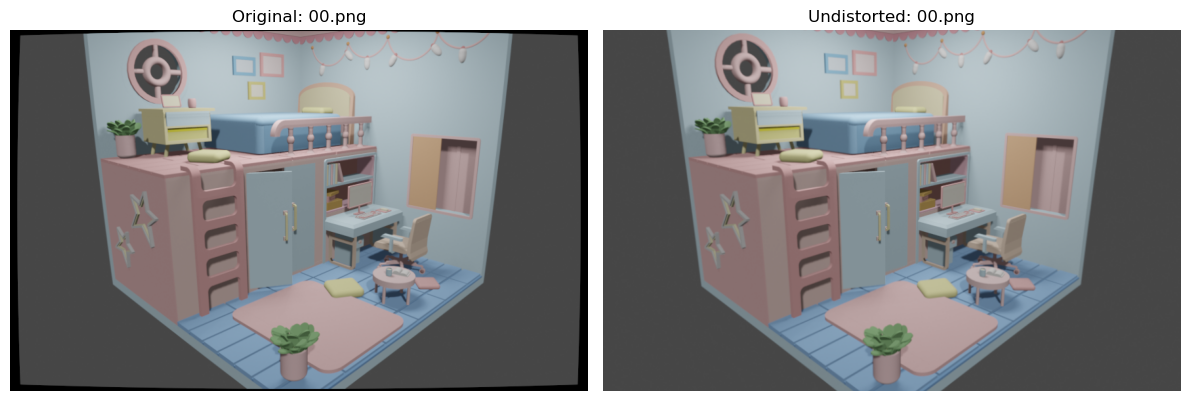

In [5]:

def get_images(img_path="data/images", depth_path=None, ext=".png"):

    files = sorted([f for f in os.listdir(img_path) if f.lower().endswith(ext)])
    rgb_images = []
    depth_images = []
    filenames = []

    for filename in files:
        rgb_bgr = cv.imread(os.path.join(img_path, filename))
        if rgb_bgr is None:
            print(f"Warning: RGB image {filename} not found or couldn't be read.")
            continue
        # convert to RGB for internal processing
        rgb = cv.cvtColor(rgb_bgr, cv.COLOR_BGR2RGB)
        rgb_images.append(rgb)
        filenames.append(filename)

        if depth_path is not None:
            depth = cv.imread(os.path.join(depth_path, filename), cv.IMREAD_UNCHANGED)
            if depth is None:
                print(f"Warning: Depth image {filename} not found.")
                depth_images.append(None)
            else:
                depth_images.append(depth)

    print(f"Loaded {len(rgb_images)} RGB images from '{img_path}'.")
    return rgb_images, depth_images, filenames


def get_K(cam_calib):
    fx = cam_calib['focal_length_px']
    fy = fx * cam_calib.get('pixel_ratio', 1.0)
    # your original indexing used [1] for cx and [0] for cy — preserve that behavior
    cx = cam_calib['principal_point'][1]
    cy = cam_calib['principal_point'][0]

    K = np.array([[fx, 0, cx],
                  [0, fy, cy],
                  [0,  0,  1]], dtype=np.float64)
    return K


def undistort_images(rgb_images, K, distortion_coeffs, H, W, new_K=None):
    if new_K is None:
        new_K = K

    # convert distortion to proper shape
    dist = np.asarray(distortion_coeffs, dtype=np.float64).reshape(-1, 1)

    # OpenCV expects size as (width, height)
    map1, map2 = cv.initUndistortRectifyMap(K, dist, None, new_K, (W, H), cv.CV_32FC1)

    undistorted_images = []
    for img in rgb_images:
        # remap expects BGR or RGB equally; remap preserves channel order
        # ensure image has correct size: if not, resize first (warn)
        if (img.shape[0], img.shape[1]) != (H, W):
            # warn and resize to the target size before remapping
            print("Warning: input image size differs from (H,W). Resizing before undistort.")
            img_resized = cv.resize(img, (W, H), interpolation=cv.INTER_LINEAR)
        else:
            img_resized = img

        # remap. OpenCV works natively with arrays in same channel order
        und = cv.remap(img_resized, map1, map2, interpolation=cv.INTER_LINEAR, borderMode=cv.BORDER_CONSTANT)
        undistorted_images.append(und)

    print(f"Successfully undistorted {len(undistorted_images)} images.")
    return undistorted_images


def save_undistorted_images(undistorted_images, filenames=None, output_dir="output/undistorted_images"):

    os.makedirs(output_dir, exist_ok=True)

    for idx, img in enumerate(undistorted_images):
        if filenames and idx < len(filenames):
            filename = filenames[idx]
        else:
            filename = f"{idx:02d}.png"

        save_path = os.path.join(output_dir, filename)

        # Convert back to BGR for saving with OpenCV
        if img.ndim == 3 and img.shape[2] == 3:
            img_bgr = cv.cvtColor(img, cv.COLOR_RGB2BGR)
        else:
            # single-channel or other: save directly
            img_bgr = img

        success = cv.imwrite(save_path, img_bgr)
        if not success:
            print(f"Failed to save {save_path}")
        else:
            print(f"Saved: {save_path}")



if __name__ == "__main__":


    print("\nSTEP 1: Read images")
    RGB_IMGS, DEPTH_IMGS, FILENAMES = get_images(img_path="data/images", depth_path=None)

    # Build intrinsics and distortion
    K = get_K(camera_calibration)
    DISTORTION_COEFFS = np.array(camera_calibration['distortion_param'])
    H, W = camera_calibration['image_height'], camera_calibration['image_width']

    print("\nSTEP 2: Undistort images")
    UNDISTORTED_RGB_IMGS = undistort_images(RGB_IMGS, K, DISTORTION_COEFFS, H, W)

    print("\nSTEP 3: Save undistorted images")
    save_undistorted_images(UNDISTORTED_RGB_IMGS, filenames=FILENAMES, output_dir="output/undistorted_images")

    # Optional: quick visual compare for the first image (if available)
    if len(RGB_IMGS) > 0 and len(UNDISTORTED_RGB_IMGS) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        axes[0].imshow(RGB_IMGS[0])
        axes[0].set_title(f'Original: {FILENAMES[0]}')
        axes[0].axis('off')
        axes[1].imshow(UNDISTORTED_RGB_IMGS[0])
        axes[1].set_title(f'Undistorted: {FILENAMES[0]}')
        axes[1].axis('off')
        plt.tight_layout()
        plt.show()


Example visualization

![title](data/samples/image_distortion.png)

<h2 style="color:#007b90">Step 2: Common Camera Reference Frame</h2>

The provided camera poses are expressed relative to consecutive frames (e.g. the first pose is a transformation from the first view to the second view). However, the final point cloud needs to be definied with respect to a single, common world coordinate system.

Compute camera poses such that they are expressed in terms of a shared world reference frame, and then visualize all camera positions and orientations in a single 3D plot.

Computed 9 world poses with correct order.


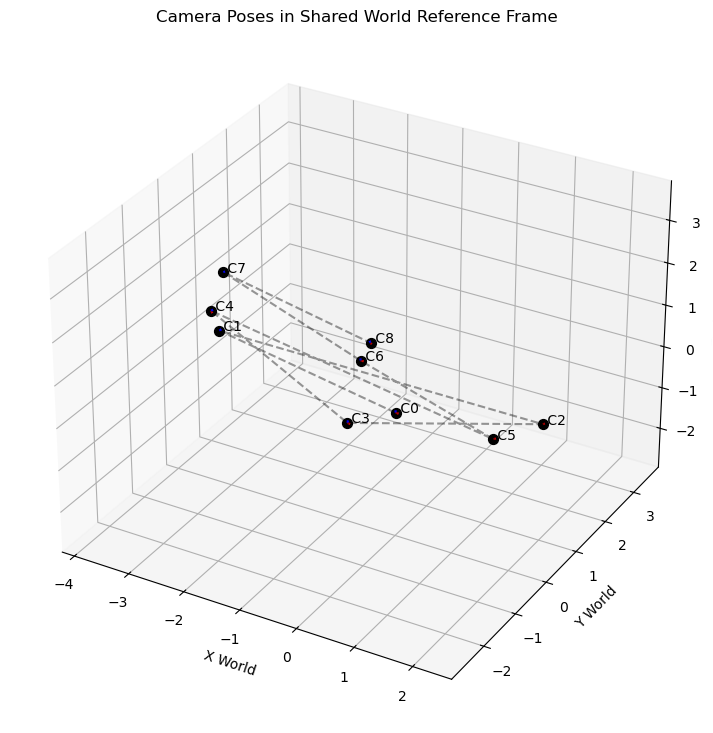

In [6]:
# --- STEP 2: Calculate World Poses : Common Camera Reference Frame ---

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def compute_world_to_camera_poses(camera_movement):
    # camera_movement[i] transforms camera i -> camera i+1.
    # Returns world->camera transforms with camera 0 at world origin.
    num_cameras = camera_movement.shape[0] + 1
    T_world_to_cam = [np.eye(4)]

    for i in range(1, num_cameras):
        # Correct chaining order: T_w2c(i+1) = T_i_to_i+1 @ T_w2c(i)
        T_world_to_cam.append(camera_movement[i - 1] @ T_world_to_cam[i - 1])

    return T_world_to_cam


def get_camera_centers(T_world_to_cam):
    centers = []
    for T in T_world_to_cam:
        R = T[:3, :3]
        t = T[:3, 3]
        centers.append(-R.T @ t)
    return np.array(centers)


T_world_to_cam = compute_world_to_camera_poses(camera_movement)
camera_centers = get_camera_centers(T_world_to_cam)

print(f"Computed {len(T_world_to_cam)} world-to-camera poses with correct order.")

# --- Visualization of Camera Trajectory ---

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

axis_scale = 0.2

for i, T in enumerate(T_world_to_cam):
    C = camera_centers[i]
    R = T[:3, :3]

    # Camera viewing direction in world coordinates
    view_dir = R.T @ np.array([0.0, 0.0, 1.0])

    ax.scatter(C[0], C[1], C[2], color='black', s=50)
    ax.text(C[0], C[1], C[2], f' C{i}', size=10)
    ax.quiver(C[0], C[1], C[2], view_dir[0], view_dir[1], view_dir[2],
              length=axis_scale, color='b', alpha=0.8)

# Connect camera centers to show path
ax.plot(camera_centers[:, 0], camera_centers[:, 1], camera_centers[:, 2], 'k--', alpha=0.4)

ax.set_xlabel('X World')
ax.set_ylabel('Y World')
ax.set_zlabel('Z World')
ax.set_title('Camera Centers in Shared World Reference Frame')

# Equalize axis scaling to prevent visual warping
max_range = np.array([
    camera_centers[:, 0].max() - camera_centers[:, 0].min(),
    camera_centers[:, 1].max() - camera_centers[:, 1].min(),
    camera_centers[:, 2].max() - camera_centers[:, 2].min()
]).max() / 2.0
mid_x = (camera_centers[:, 0].max() + camera_centers[:, 0].min()) * 0.5
mid_y = (camera_centers[:, 1].max() + camera_centers[:, 1].min()) * 0.5
mid_z = (camera_centers[:, 2].max() + camera_centers[:, 2].min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.show()


Example visualization

![title](data/samples/cameras.png)

<h2 style="color:#007b90">Step 3: Feature Matching and Depth Map Scaling</h2>

Each depth map is scaled differently according to its own maximum value. To obtain a consistent dense point cloud, we must correct these scalings so that 3D points from different views align properly.

Perform feature matching across the images, and use the corresponding matches to determine the correct scale factors for the depth maps.
Additionally, visualize one selected feature across all views.

Successfully loaded 9 depth maps.
Epipolar matching complete for all 7 features.
Images   | Scale Value
Img 00   | 1.000
Img 01   | 1.000
Img 02   | 1.038
Img 03   | 1.137
Img 04   | 1.496
Img 05   | 0.601
Img 06   | 1.072
Img 07   | 2.179
Img 08   | 2.179


/var/folders/2f/9svfc8fn0ybfbhmfbftv5z1w0000gn/T/ipykernel_51361/1255024889.py:65: RuntimeWarning: divide by zero encountered in divide
  pts3D = pts4D[:3, :] / pts4D[3, :]


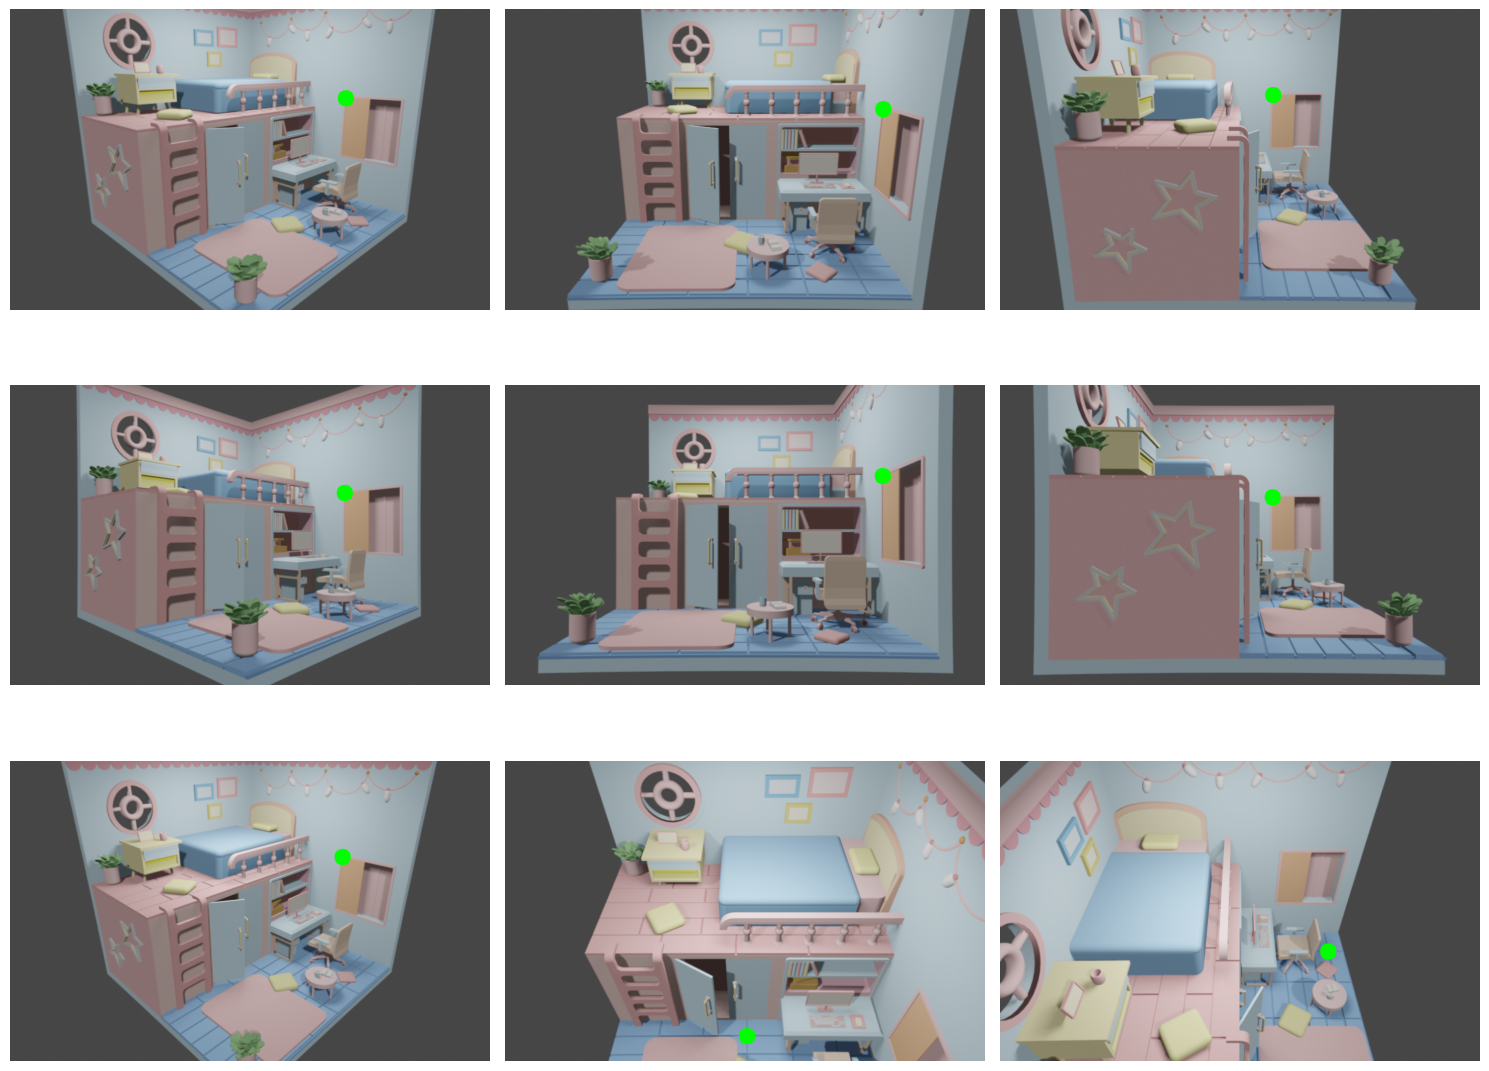

In [7]:
# Updated loading logic for Step 3
def load_depth_only(depth_path):
    files = sorted([f for f in os.listdir(depth_path) if f.lower().endswith('.png')])
    depth_images = []
    for f in files:
        # Depth images are usually 16-bit or 8-bit; IMREAD_UNCHANGED preserves this
        d = cv.imread(os.path.join(depth_path, f), cv.IMREAD_UNCHANGED)
        depth_images.append(d)
    return depth_images

# depth_path was already defined as data_path/depths
DEPTH_IMGS = load_depth_only(depth_path)
print(f"Successfully loaded {len(DEPTH_IMGS)} depth maps.")

# Use a fixed Z_max for all images (room depth = 3 meters)
ROOM_DEPTH_M = 3.0
final_scales = [ROOM_DEPTH_M] * len(DEPTH_IMGS)

print("Using fixed depth scale for all images:")
print(f"  Z_max = {ROOM_DEPTH_M:.1f} m")
print(f"{'Images':<8} | {'Scale Value'}")
for i, s in enumerate(final_scales):
    print(f"Img {i:02d}   | {float(s):.3f}")

# -------------------------------------------------------------------
# 3.1) Feature Matching (Sorting the 7 features using Epipolar Geometry)
# -------------------------------------------------------------------

def get_F_matrix(K, R, t):
    t_skew = np.array([[0, -t[2], t[1]], [t[2], 0, -t[0]], [-t[1], t[0], 0]])
    E = t_skew @ R
    F = np.linalg.inv(K).T @ E @ np.linalg.inv(K)
    return F

# Intrinsic matrix from your helper
K_mat = get_K(camera_calibration)

# Store matched indices: sorted_indices[img_idx] gives the matching order
sorted_matches = []

for i in range(len(DEPTH_IMGS) - 1):
    T = camera_movement[i]
    R, t = T[:3, :3], T[:3, 3]
    F = get_F_matrix(K_mat, R, t)

    # Feature matching by minimizing distance to epipolar line
    match_map = []
    for feat_a in given_features[i]:
        p1 = np.array([feat_a[1], feat_a[0], 1.0])
        line_in_b = F @ p1

        dists = []
        for feat_b in given_features[i + 1]:
            p2 = np.array([feat_b[1], feat_b[0], 1.0])
            d = abs(np.dot(p2, line_in_b)) / np.sqrt(line_in_b[0]**2 + line_in_b[1]**2)
            dists.append(d)
        match_map.append(np.argmin(dists))
    sorted_matches.append(match_map)

print("Epipolar matching complete for all 7 features.")

# Track the 0th feature from the first image
current_idx = 0
tracking = [current_idx]
for i in range(len(sorted_matches)):
    current_idx = sorted_matches[i][current_idx]
    tracking.append(current_idx)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

step3_out_path = os.path.join(out_path, "step 3 output")
os.makedirs(step3_out_path, exist_ok=True)
for i in range(len(UNDISTORTED_RGB_IMGS)):
    img = UNDISTORTED_RGB_IMGS[i].copy()
    img_draw = UNDISTORTED_RGB_IMGS[i].copy()
    img_bgr = cv.cvtColor(img_draw, cv.COLOR_RGB2BGR)
    feat_idx = tracking[i]
    h, w = given_features[i][feat_idx]

    cv.circle(img, (int(w), int(h)), 15, (0, 255, 0), -1)
    save_file = os.path.join(step3_out_path, f"tracked_view_{i:02d}.png")
    cv.imwrite(save_file, img_bgr)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Example visualization of the 7 features

![title](data/samples/00_features.png)

<h2 style="color:#007b90">Step 4: Depth Map to 3D Points</h2>

Using the rescaled depth maps together with the camera poses from Step 2, compute the 3D coordinates for all pixel in each RGB image.

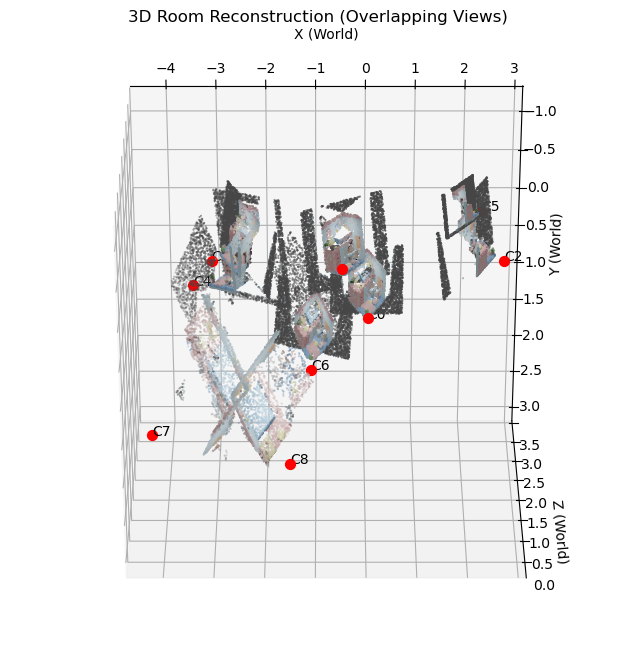

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Use world-to-camera poses from Step 2 ---
world_to_cam = T_world_to_cam

# --- 2. Generate Dense 3D Points ---
all_points = []
all_colors = []

# Get intrinsics from K_mat (from Step 3)
fx, fy = K_mat[0, 0], K_mat[1, 1]
cx, cy = K_mat[0, 2], K_mat[1, 2]

for i in range(len(DEPTH_IMGS)):
    depth_map = DEPTH_IMGS[i]
    rgb_img = UNDISTORTED_RGB_IMGS[i]
    scale = final_scales[i]  # Fixed Z_max from Step 3

    # Create pixel grid
    h, w = depth_map.shape
    u, v = np.meshgrid(np.arange(w), np.arange(h))
    u_f, v_f = u.flatten(), v.flatten()

    # Metric Depth calculation: Z = (raw/255) * Z_max
    z_f = (depth_map.flatten().astype(float) / 255.0) * scale

    # Filter valid pixels (depth > 0)
    mask = z_f > 0
    u_f, v_f, z_f = u_f[mask], v_f[mask], z_f[mask]

    # Back-project to Camera Frame
    x_c = (u_f - cx) * z_f / fx
    y_c = (v_f - cy) * z_f / fy
    z_c = z_f

    # Transform to World Frame using cam-to-world
    pts_hom = np.vstack((x_c, y_c, z_c, np.ones_like(z_f)))
    T_cam_to_world = np.linalg.inv(world_to_cam[i])
    pts_world = (T_cam_to_world @ pts_hom).T

    all_points.append(pts_world[:, :3])
    all_colors.append(rgb_img[v_f, u_f] / 255.0)  # Normalize for plotting

# Combine for visualization
combined_pts = np.vstack(all_points)
combined_cols = np.vstack(all_colors)

# --- 3. 3D Plotting (Visualization) ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Subsample points for performance (plotting 4 million points will freeze)
sample_idx = np.random.choice(len(combined_pts), 50000, replace=False)
pts_plot = combined_pts[sample_idx]
cols_plot = combined_cols[sample_idx]

# Scatter plot
ax.scatter(pts_plot[:, 0], pts_plot[:, 1], pts_plot[:, 2], c=cols_plot, s=0.2)

# Plot Camera centers to verify the path
for i, C in enumerate(camera_centers):
    ax.scatter(C[0], C[1], C[2], c='red', s=50)
    ax.text(C[0], C[1], C[2], f"C{i}", color='black')

ax.set_title("3D Room Reconstruction (Overlapping Views)")
ax.set_xlabel("X (World)")
ax.set_ylabel("Y (World)")
ax.set_zlabel("Z (World)")

# Set view to see the room interior
ax.view_init(elev=-60, azim=-90)
plt.show()


Example visualization of cameras and 3D points (of the 7 features) from one image

![title](data/samples/features.png)

<h2 style="color:#007b90">Step 5: 3D Points to Point Cloud</h2>

Finally, use the provided `ply_creator` function to generate a merged colored point cloud from the computed 3D points from all images. Visualize the resulting point cloud in a viewer such as MeshLab.

In [11]:
# --- STEP 5: Merged all points and exported PLY file ---

import os
import numpy as np

# 1. Helper Function: Check for variables and consolidate data
def get_point_data():
    # Check for the various names we might have used in Step 4
    if 'combined_pts' in globals() and 'combined_cols' in globals():
        print("Found data from Visualization Step (combined_pts)")
        return combined_pts, combined_cols
    elif 'combined_points' in globals() and 'combined_colors' in globals():
        print("Found data from Standard Step 4 (combined_points)")
        return combined_points, combined_colors
    elif 'all_points_world' in globals() and 'all_points_colors' in globals():
        print("Found list data from Step 4 (all_points_world)")
        # If they are lists, stack them
        if isinstance(all_points_world, list):
            return np.vstack(all_points_world), np.vstack(all_points_colors)
        return all_points_world, all_points_colors
    elif 'all_points' in globals() and 'all_colors' in globals():
        print("Found list data from Visualization Step (all_points)")
        if isinstance(all_points, list):
            return np.vstack(all_points), np.vstack(all_colors)
        return all_points, all_colors
    else:
        raise ValueError("No 3D point data found! Please re-run Step 4.")

# 2. PLY Creator Function
def ply_creator(points, colors, output_file):
    # Ensure colors are uint8 (0-255)
    if colors.max() <= 1.0:
        colors = (colors * 255).astype(np.uint8)
    else:
        colors = colors.astype(np.uint8)
        
    # Header
    header = [
        "ply",
        "format ascii 1.0",
        f"element vertex {len(points)}",
        "property float x",
        "property float y",
        "property float z",
        "property uchar red",
        "property uchar green",
        "property uchar blue",
        "end_header"
    ]
    
    # Merge points and colors
    data = np.hstack((points, colors))
    
    # Write to file
    print(f"Writing {len(points):,} points to {output_file} ...")
    # Using raw write for header, savetxt for data (efficient)
    with open(output_file, 'w') as f:
        f.write('\n'.join(header) + '\n')
        np.savetxt(f, data, fmt="%.4f %.4f %.4f %d %d %d")
    
    return output_file

# --- Main Execution ---

try:
    # 3. Retrieve Data
    final_points, final_colors = get_point_data()
    
    # 4. Define Output
    output_dir = os.path.join('output', 'point_cloud')
    os.makedirs(output_dir, exist_ok=True)
    output_filename = os.path.join(output_dir, 'dense_reconstruction.ply')
    
    # 5. Export
    saved_path = ply_creator(final_points, final_colors, output_filename)
    
    print(f"============================================================")
    print(f"✓ Step 5 Complete: PLY file exported successfully.")
    print(f"Location: {saved_path}")
    print(f"============================================================")

except Exception as e:
    print(f"ERROR: {e}")
    print("Tip: If you see 'No 3D point data found', go back and run the Step 4 cell again.")

Found data from Visualization Step (combined_pts)
Writing 4,368,879 points to output/point_cloud/dense_reconstruction.ply ...
✓ Step 5 Complete: PLY file exported successfully.
Location: output/point_cloud/dense_reconstruction.ply


Example visualization

![title](data/samples/dense_point_cloud.png)